<a href="https://www.kaggle.com/code/siizerr/movie-correlation-and-eda-visualization?scriptVersionId=125217815" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Ask Question to make Data Driven Decision Making

Apa yang ingin kita ketahui dari list film di sini?

* Film negara mana yang banyak di tonton?
* Negara mana yang banyak menonton?
* Apa rating yang banyak ditonton?
* Apa saja film dengan budget terbesar?
* Film apa saja yang paling terkenal?
* Bagaimana korelasi/hubungan budget dan pendapatan?
* Apakah company memengaruhi pendapatan? Seberapa besar?
* Apakah votes memengaruhi pendapatan? Seberapa besar?
* Hal apa saja yang memengaruhi pendapatan?

# Importing Data

In [1]:
#Import libraries

#pandas digunakan untuk memanipulasi dan analisis data
#seaborn digunakan visualisasi data
#matplotlib digunakan untuk menyetel atau mengatur visualisasi data


import numpy as np 
import pandas as pd 
import seaborn as sns
import re
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use ('ggplot')
from matplotlib import figure

%matplotlib inline
sns.set()


import os  
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/moviess/New Movie.csv
/kaggle/input/moviesdataset/New Movie.csv


In [2]:
df = pd.read_csv('/kaggle/input/moviesdataset/New Movie.csv')

df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,13/06/1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,02/07/1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,20/06/1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,02/07/1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,25/07/1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


**Membaca tipe data**

In [3]:
df.dtypes

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

The set has:
* Numerical columns: Budget, Gross, Runtime, Score and Votes.
* Categorical columns: Company, Country, Director, Genre, Name, Rating, Star, Released and Writer.
* Integer: Year.


In [4]:
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts>0])

rating       76
score         3
votes         3
writer        2
star          1
country       1
budget     2130
gross       179
company      15
runtime       2
dtype: int64


# **Cleaning Data**

1. replace the missing rows in rating, score, votes by mode
2. replace the writer, star, and company by unknown 
3. replace the country by matching with the company
4. we can't change the budget and gross so replace them by 0 
5. change data types of release become datetime
6. drop cuplicate column in name

In [5]:
df.dtypes

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

## 1. Drop Duplicate rows in column name

In [6]:
#count the duplicate 
dup = df.duplicated(subset = ['name', 'star'])
num_dup = dup.sum()

print(f'The numbers of duplicates is: {num_dup}')

#showing the duplicate
df.sort_values('name', inplace = True)
bool_series = df[['name', 'star']].duplicated()
df[bool_series]


The numbers of duplicates is: 1


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
3674,Shaft,R,Action,2000,16/06/2000,6.0,75000.0,John Singleton,Ernest Tidyman,Samuel L. Jackson,Germany,46000000.0,107626125.0,Paramount Pictures,99.0


In [7]:
#keep the first diplicate row
df.drop_duplicates(subset = ['name', 'star'], inplace = True)
df.drop(['name', 'star'], axis = 1, inplace = True)

## 2. Replace missing rows in rating, score, votes by mode

In [8]:
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

df['score'] = df['score'].fillna(df['score'].mode()[0])

df['votes'] = df['votes'].fillna(df['votes'].mode()[0])

## 3. Replace the writer, star, and company by unknown

In [9]:
df.fillna({'writer' : 'Unknown', 'star' : 'Unknown', 'company' : 'Unknown'}, inplace = True)

## 4. Replace the country by matching with the company

In [10]:
#check words that maybe we can use for replace the missing value in country
mask = (df['country'].isnull())

selected_df = df.loc[mask, ['country', 'company']]

selected_df


,country,company
7559,NaN,Growing Tree Productions


In [11]:
# check the Tree and match them with country

df['company'] = df['company'].astype('string') 

mask = df['company'] & df['company'].str.contains('Growing Tree Production', na=False)

selected_df = df.loc[mask, ['country', 'company']]

selected_df

#we not get anything so prefer we drop it

df.dropna(subset = ['country'], inplace = True)
df.dropna(subset = ['runtime'], inplace = True)

## 5. change data types of release become datetime

In [12]:
df['released'] = pd.to_datetime(df['released'])


## 6. change the budget and gross so replace them by 0

In [13]:
df.fillna({'budget' : '0', 'gross' : '0'}, inplace = True)

In [14]:
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts>0])

Series([], dtype: int64)


# 1. EDA Visualization

We should understanding the basic information of the data. Let's check it first

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,7608.0,2000.482256,11.137108,1980.0,1991.0,2001.0,2010.0,2020.0
score,7608.0,6.390352,0.968166,1.9,5.8,6.5,7.1,9.3
votes,7608.0,88684.247766,163786.266707,7.0,9300.0,33000.0,94000.0,2400000.0
runtime,7608.0,107.290352,18.616869,55.0,95.0,104.0,116.0,366.0


#NOTE

df.describe() is a pandas method that returns a summary of the statistics of a DataFrame. The T attribute transposes the DataFrame, so that the rows become columns and the columns become rows.

The resulting transposed DataFrame will have the following columns:

* count: the number of non-missing (non-NaN) values in each column
* mean: the arithmetic mean (average) of each column
* std: the standard deviation of each column
* min: the minimum value of each column
* 25%: the 25th percentile (1st quartile) of each column
* 50%: the 50th percentile (median) of each column
* 75%: the 75th percentile (3rd quartile) of each column
* max: the maximum value of each column

condlusion: 
* we have 7612 titles of films
* the studied time lapse goes from 1986 to 2016


### How many films released per year?

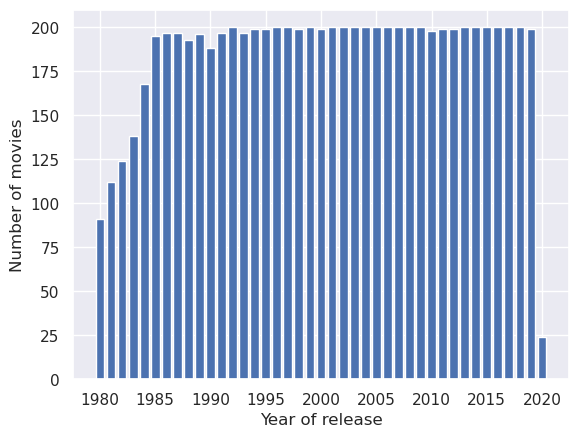

In [16]:
counts = df['year'].value_counts().sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel('Year of release')
plt.ylabel('Number of movies')
plt.show()


### What is the oldest and the newest movie?

In [17]:
df = pd.read_csv('/kaggle/input/moviesdataset/New Movie.csv')

In [18]:
Oldest = df.sort_values('released', ascending = True)

#specify the column we want to show
Oldest[['name', "released"]] [:5]


,name,released
197,Scream,01/01/1981
173,Pennies from Heaven,01/01/1982
179,Zoot Suit,01/01/1982
621,Windy City,01/01/1986
2440,Texas Chainsaw Massacre: The Next Generation,01/01/1994


In [19]:
Newest = df.sort_values("released", ascending = False)

#specify the column we want to show
Newest[['name', "released"]][:10]

,name,released
4134,Dahmer,31/12/2018
6357,Romeo and Juliet,31/12/2012
3572,Liberty Heights,31/12/1999
3187,Oscar and Lucinda,31/12/1997
6398,Nightcrawler,31/10/2014
6488,Before I Go to Sleep,31/10/2014
5778,Hatchet II,31/10/2010
5215,RocknRolla,31/10/2008
5206,Zack and Miri Make a Porno,31/10/2008
5309,Rachel Getting Married,31/10/2008


### What country most released films?

In [20]:
#create a code data for shorting the data

country = df.groupby('country')['name'].count()
country = country.sort_values(ascending = False)
top10 = country.head(10)

top10

country
United States     5454
United Kingdom     804
France             271
Canada             188
Germany            117
Australia           91
Japan               80
India               62
Italy               60
Spain               47
Name: name, dtype: int64

Let's check just 10 countires

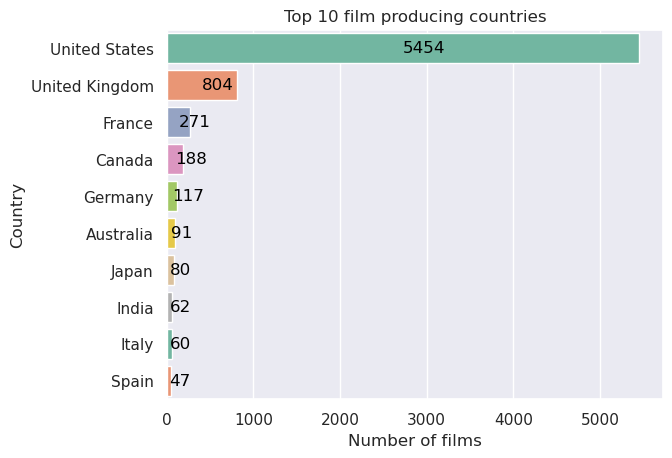

In [21]:
my_palette = sns.color_palette("Set2", 10)
country = df.groupby('country')['name'].count()
country = country.sort_values(ascending=False)
top10 = country.head(10)

sns.barplot(y=top10.index, x=top10.values, palette=my_palette, orient='h')
plt.title('Top 10 film producing countries')
plt.xlabel('Number of films')
plt.ylabel('Country')

plt.xticks(rotation=0, ha='center')

for i, count in enumerate(top10.values):
    plt.text(count/2, i, count, ha='left', va='center', color='black', fontweight='medium')

plt.show()


### Country most release film and the genre

In [22]:
#group by year and genre to get count of country
dfg = df.groupby([df.country, 'genre']).genre.count().reset_index(name='count')

#pivot into correct form for stcaked bar 
dfp = dfg.pivot(index = 'country', columns = 'genre', values = 'count')

#get the top 5
top3_countries = dfp.sum(axis = 1).sort_values(ascending = False).head(3).index

#plot top 5
top3 = dfp.loc[top3_countries]

top3

genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,Western
country,,,,,,,,,,,,,,,,,,,
United States,1297.0,277.0,237.0,251.0,1794.0,380.0,896.0,9.0,34.0,NaN,245.0,NaN,NaN,14.0,3.0,7.0,1.0,8.0,1.0
United Kingdom,125.0,75.0,16.0,109.0,188.0,52.0,200.0,1.0,1.0,NaN,24.0,NaN,2.0,1.0,4.0,2.0,NaN,3.0,1.0
France,46.0,16.0,10.0,19.0,50.0,23.0,96.0,NaN,1.0,NaN,3.0,1.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN


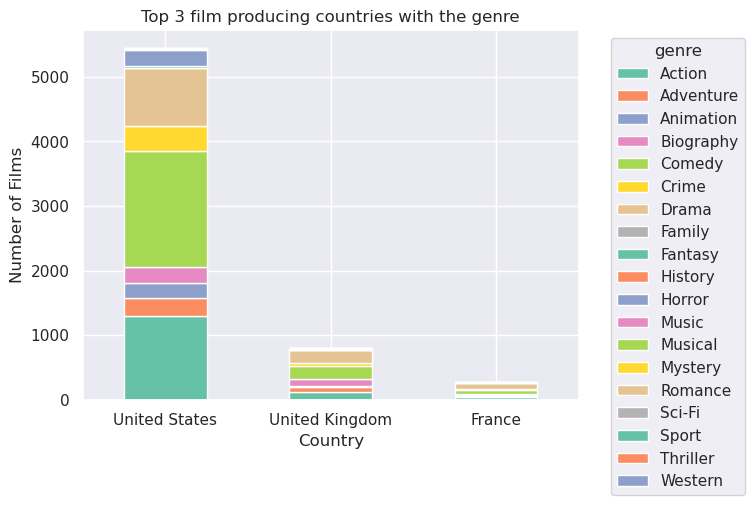

In [23]:
#get the top 5
top3_countries = dfp.sum(axis = 1).sort_values(ascending = False).head(3).index

#plot top 5
top3 = dfp.loc[top3_countries]
my_palette = sns.color_palette("Set2")
sns.set_palette(my_palette)

top3.plot.bar(stacked = True, xlabel = 'Country', ylabel = 'Number of Films', edgecolor = None, )
plt.title('Top 3 film producing countries with the genre')
plt.legend(title = 'genre', bbox_to_anchor = (1.05,1), loc = 'upper left')
plt.xticks(rotation = 0)

plt.show()

### most watched genre

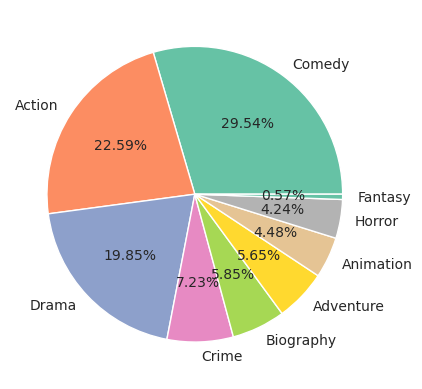

In [24]:
#counts the genre 
genre_c = df['genre'].value_counts()

#get the top 9
top9_genre = genre_c.sort_values(ascending = False).head(9).index

#plot top 5
top9 = genre_c.loc[top9_genre]

labels = top9.index
sizes = top9.values

plt.pie(sizes, labels = labels, autopct = '%1.2f%%', textprops = {'fontsize' : 10}, colors = sns.color_palette('Set2'))

plt.show()

In [25]:
#change data type 'company' to string
df['company'] = df['company'].astype(str)

#drop any duplication
df['company'].drop_duplicates().sort_values(ascending=False)



7073                                thefyzz
403                                     nan
5611                            micro_scope
6356               iDeal Partners Film Fund
3954                               i5 Films
                       ...                 
5758                        10 West Studios
3695                     1+2 Seisaku Iinkai
2972                        .406 Production
7469    "Weathering With You" Film Partners
4292        "DIA" Productions GmbH & Co. KG
Name: company, Length: 2362, dtype: object

## Companies that often release film

In [26]:
#create a code data for shorting the data

companies = df.groupby('company')['name'].count()
companies = companies.sort_values(ascending = False)
top10 = companies.head(10)

top10

company
Universal Pictures           377
Warner Bros.                 334
Columbia Pictures            332
Paramount Pictures           320
Twentieth Century Fox        239
New Line Cinema              174
Touchstone Pictures          132
Metro-Goldwyn-Mayer (MGM)    124
Walt Disney Pictures         123
TriStar Pictures              93
Name: name, dtype: int64

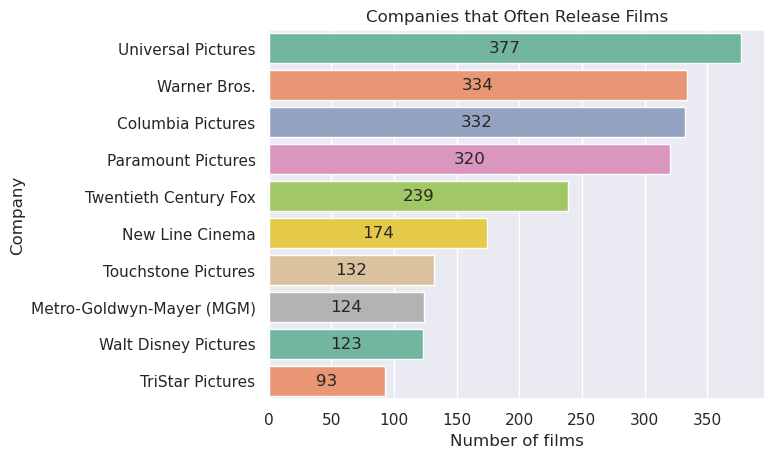

In [27]:
companies = df.groupby('company')['name'].count()
companies = companies.sort_values(ascending = False)
top10 = companies.head(10)

my_palette = sns.color_palette('Set2')
sns.set_palette(my_palette)

ax = sns.barplot(x = top10.values, y = top10.index, palette = my_palette, orient = 'h')
plt.title('Companies that Often Release Films')
plt.xlabel('Number of films')
plt.ylabel('Company')
plt.xticks(rotation = 0)

for i, count in enumerate(top10.values):
    ax.text(count/2, i, count, ha='center', va='center', fontweight='medium')

plt.show()

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,7612.0,2.000489e+03,1.113923e+01,1980.0,1991.0,2001.0,2010.0,2.020000e+03
score,7609.0,6.389920e+00,9.682334e-01,1.9,5.8,6.5,7.1,9.300000e+00
votes,7609.0,8.868297e+04,1.637758e+05,7.0,9300.0,33000.0,94000.0,2.400000e+06
budget,5482.0,3.567303e+07,4.148239e+07,3000.0,10000000.0,21000000.0,45000000.0,3.560000e+08
gross,7433.0,7.897999e+07,1.661247e+08,309.0,4634077.0,20387597.0,76419755.0,2.847246e+09
runtime,7610.0,1.072853e+02,1.861790e+01,55.0,95.0,104.0,116.0,3.660000e+02


# 2. Find the Correlation of the Parameter

I want to check the parameter that affect the gross. 

In [29]:
#Sort the 'gross' from the descending value

df = df.sort_values(['gross'], ascending=False)

df

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5392,Avatar,PG-13,Action,2009,18/12/2009,7.8,1100000.0,James Cameron,James Cameron,Sam Worthington,United States,237000000.0,2.847246e+09,Twentieth Century Fox,162.0
7389,Avengers: Endgame,PG-13,Action,2019,26/04/2019,8.4,903000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000.0,2.797501e+09,Marvel Studios,181.0
2993,Titanic,PG-13,Drama,1997,19/12/1997,7.8,1100000.0,James Cameron,James Cameron,Leonardo DiCaprio,United States,200000000.0,2.201647e+09,Twentieth Century Fox,194.0
6607,Star Wars: Episode VII - The Force Awakens,PG-13,Action,2015,18/12/2015,7.8,876000.0,J.J. Abrams,Lawrence Kasdan,Daisy Ridley,United States,245000000.0,2.069522e+09,Lucasfilm,138.0
7188,Avengers: Infinity War,PG-13,Action,2018,27/04/2018,8.4,897000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000.0,2.048360e+09,Marvel Studios,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7607,More to Life,NaN,Drama,2020,23/10/2020,3.1,18.0,Joseph Ebanks,Joseph Ebanks,Shannon Bond,United States,7000.0,NaN,nan,90.0
7608,Dream Round,NaN,Comedy,2020,07/02/2020,4.7,36.0,Dusty Dukatz,Lisa Huston,Michael Saquella,United States,NaN,NaN,Cactus Blue Entertainment,90.0
7609,Saving Mbango,NaN,Drama,2020,27/04/2020,5.7,29.0,Nkanya Nkwai,Lynno Lovert,Onyama Laura,United States,58750.0,NaN,Embi Productions,NaN
7610,It's Just Us,NaN,Drama,2020,01/10/2020,NaN,NaN,James Randall,James Randall,Christina Roz,United States,15000.0,NaN,nan,120.0


From above data, maybe we can say that parameter that can affect the increasing value of gross are:
* budget
* company

Now let's have a look our hypotesis by visualisation all the parameter 

# Check Correlation Gross and Budget

<AxesSubplot:xlabel='budget', ylabel='gross'>

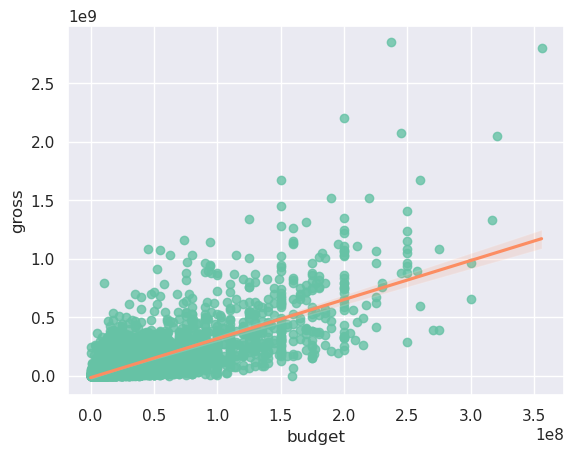

In [30]:

df['budget'] = pd.to_numeric(df['budget'], errors = 'coerce')
df['gross'] = pd.to_numeric(df['gross'], errors = 'coerce')
df = df.dropna()

my_palette = sns.color_palette('Set2')
sns.set_palette(my_palette)

sns.regplot(x = 'budget', y = 'gross', data = df, line_kws = {'color' : 'C1'})


By the picture, we can know that budget is affect the increasing value of gross. So our hypothesis is correct. 

But we need to know the value and check again if there any parameter that most affect than the budget for the gross.

In [31]:
#corr is formula to show the linear correlation in 2 variabel by column 
# 1 mean positive correlation
# -1 mean negative correlation

df.corr(method = 'pearson')

,year,score,votes,budget,gross,runtime
year,1.000000,0.055855,0.204898,0.326655,0.273472,0.074705
score,0.055855,1.000000,0.474759,0.071983,0.222744,0.414729
votes,0.204898,0.474759,1.000000,0.439217,0.614501,0.352379
budget,0.326655,0.071983,0.439217,1.000000,0.740076,0.318538
gross,0.273472,0.222744,0.614501,0.740076,1.000000,0.275776
runtime,0.074705,0.414729,0.352379,0.318538,0.275776,1.000000


from the column, we can see that budget is true correlated to affect increasing the gross (0.7)

Now we visualising correlation the parameter to each other. Every cell indicated how srong the correlation of two parameters. 

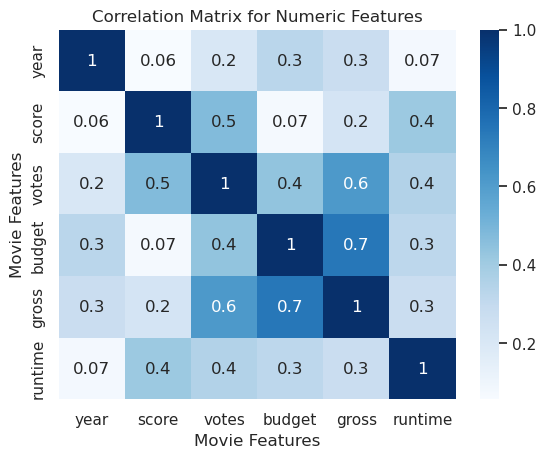

In [32]:
#Visualising correlation the parameter to each other

correlation_matrix = df.corr(method = 'pearson')

sns.set_theme(style="white")

sns.heatmap(correlation_matrix, annot = True, cmap = 'Blues', fmt = '.1g')

plt.title('Correlation Matrix for Numeric Features')

plt.xlabel('Movie Features')

plt.ylabel('Movie Features')

plt.show()

# Check Correlation Gross VS Company

In [33]:
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5392,Avatar,PG-13,Action,2009,18/12/2009,7.8,1100000.0,James Cameron,James Cameron,Sam Worthington,United States,237000000.0,2.847246e+09,Twentieth Century Fox,162.0
7389,Avengers: Endgame,PG-13,Action,2019,26/04/2019,8.4,903000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000.0,2.797501e+09,Marvel Studios,181.0
2993,Titanic,PG-13,Drama,1997,19/12/1997,7.8,1100000.0,James Cameron,James Cameron,Leonardo DiCaprio,United States,200000000.0,2.201647e+09,Twentieth Century Fox,194.0
6607,Star Wars: Episode VII - The Force Awakens,PG-13,Action,2015,18/12/2015,7.8,876000.0,J.J. Abrams,Lawrence Kasdan,Daisy Ridley,United States,245000000.0,2.069522e+09,Lucasfilm,138.0
7188,Avengers: Infinity War,PG-13,Action,2018,27/04/2018,8.4,897000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000.0,2.048360e+09,Marvel Studios,149.0


The company column has a string data type. It's difficult to do if we want to sort or visualising it. 

So we must to change the data type from string into numeric. 

In [34]:
df_numerized = df.copy()

for col_name in df.select_dtypes(include = ['object']).columns: 
    df_numerized[col_name] = df_numerized[col_name].astype('category')
    df_numerized[col_name] = df_numerized[col_name].cat.codes
        
df_numerized    

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5392,386,5,0,2009,1386,7.8,1100000.0,782,1260,1528,47,237000000.0,2.847246e+09,1377,162.0
7389,388,5,0,2019,2005,8.4,903000.0,105,510,1464,47,356000000.0,2.797501e+09,979,181.0
2993,4898,5,6,1997,1464,7.8,1100000.0,782,1260,1068,47,200000000.0,2.201647e+09,1377,194.0
6607,3634,5,0,2015,1388,7.8,876000.0,766,1803,355,47,245000000.0,2.069522e+09,941,138.0
7188,389,5,0,2018,2085,8.4,897000.0,105,510,1464,47,321000000.0,2.048360e+09,979,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5587,3784,6,6,2009,1073,5.8,3500.0,584,2920,1492,47,3000000.0,5.073000e+03,1380,96.0
2384,2960,5,0,1993,253,4.5,1900.0,1804,3097,185,47,5000000.0,2.970000e+03,1371,97.0
3628,1589,3,6,2000,780,6.8,43000.0,949,1680,525,6,5000000.0,2.554000e+03,463,108.0
270,2900,6,9,1982,846,3.9,2300.0,261,54,1467,47,800000.0,2.270000e+03,579,85.0


Then we do the same thing as budget affect gross to this parameter

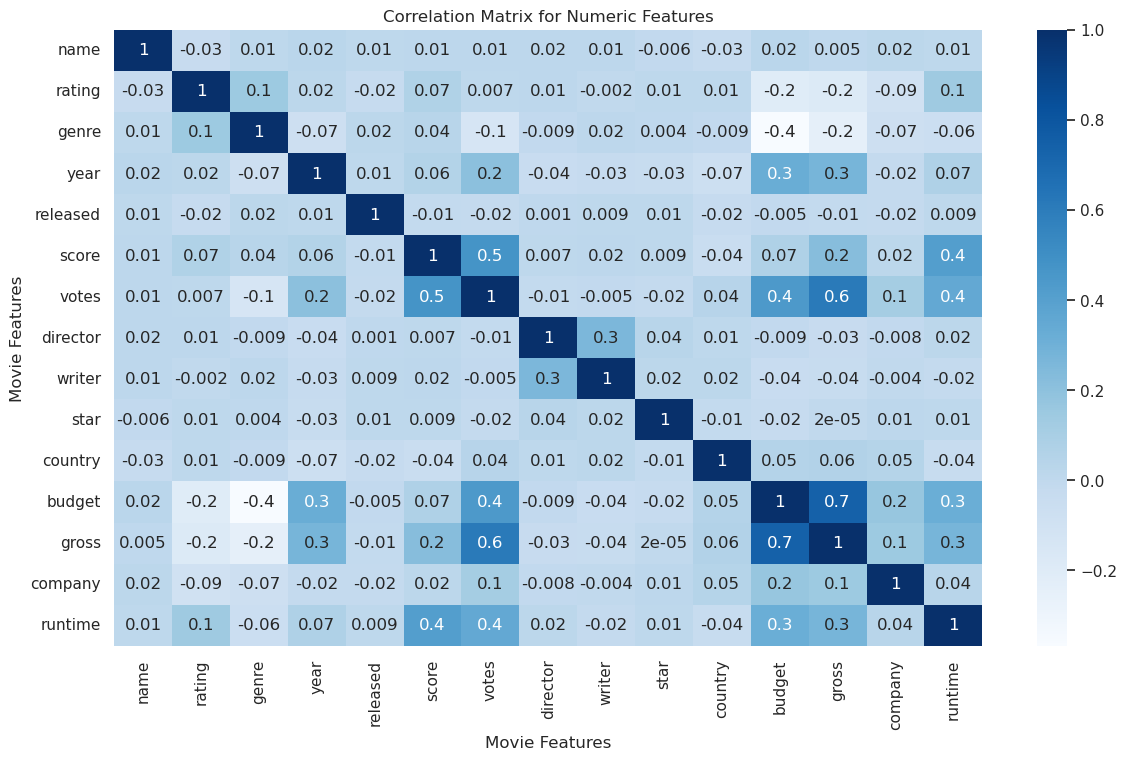

In [35]:
plt.figure(figsize = (14,8))

sns.set_theme(style = 'white')

correlation_matrix = df_numerized.corr()

sns.heatmap(correlation_matrix, annot = True, cmap = 'Blues', fmt = '.1g')

plt.title('Correlation Matrix for Numeric Features')

plt.xlabel('Movie Features')

plt.ylabel('Movie Features')

plt.show()

By the pictures, we can simply coclude that gross is high correlated with:
* budget (0.71)
* votes (0.63)

Okey, let's check them again without visualisation


In [36]:
#short the correlation
correlation_mat = df_numerized.corr()
corr_pairs = correlation_mat.unstack()
corr_pairs



name     name        1.000000
         rating     -0.029285
         genre       0.010943
         year        0.024431
         released    0.010243
                       ...   
runtime  country    -0.035624
         budget      0.318538
         gross       0.275776
         company     0.036362
         runtime     1.000000
Length: 225, dtype: float64

In [37]:
sorted_pairs = corr_pairs.sort_values()

sorted_pairs

genre    budget    -0.367921
budget   genre     -0.367921
gross    genre     -0.243392
genre    gross     -0.243392
rating   budget    -0.203238
                      ...   
year     year       1.000000
genre    genre      1.000000
rating   rating     1.000000
company  company    1.000000
runtime  runtime    1.000000
Length: 225, dtype: float64

In [38]:
#short correlation with condition the value <0.5 and not equal 1
high_corr = sorted_pairs[(sorted_pairs > 0.5) & (sorted_pairs != 1)]

high_corr 

gross   votes     0.614501
votes   gross     0.614501
budget  gross     0.740076
gross   budget    0.740076
dtype: float64

## Bagaimana korelasi/hubungan budget dan pendapatan?
Budget dalam pembuatan film memiliki hubungan berbanding lurus dengan peningkatan pendapatan yang dihasilkan. Bisa dikatakan, bduget semakin besar maka pendapatan(gross) yang dihasilkan juga akan semakin tinggi. 

## Apakah company/perusahaan memengaruhi pendapatan?
Perusahaan hanya memiliki pengaruh 0.1 terhadap gross(pendapatan). Bisa dikatakan bahwa perusahaan tidak terlalu memengaruhi besarnya pendapatan.


## Apakah votes memengaruhi pendapatan? Seberapa besar?
Votes memiliki korelasi sebesar 0.6 untuk pendapatan. Votes semakin tinggi memperlihatkan bahwa pendapatan yang dihasilkan juga akan semakin besar. Bisa jadi karena votes menandakan seberapa tinggi/bagus kualitas dari film tersebut. 


## Hal apa saja yang memengaruhi pendapatan tinggi?
Yang memengaruhi pendapatan (gross) adalah :
* Budget
* Votes